In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import torch


from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from src.word_to_embedding import WordToEmbedding

RANDOM_STATE = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
w2e = WordToEmbedding()

In [3]:
def generate_label_mapping(data: pd.DataFrame):
    label_to_id = {item: i for i, item in enumerate(set(data['произход']))}
    id_to_label = {index: label for label, index in label_to_id.items()}

    return label_to_id, id_to_label

In [4]:
class LoanwordsDataset(Dataset):
    def __init__(self, data: pd.DataFrame, label_to_id: dict[str, int], embeddeing_engine: WordToEmbedding):
        self.__data = data
        self.__len = self.__data.shape[0]
        
        self.__label_mapping = label_to_id
        self.__embeddeing_engine = embeddeing_engine


    def __len__(self):
        return self.__len

    def __getitem__(self, index) -> tuple[str, str]:
        entry = self.__data.iloc[index]

        word = entry['дума']
        origin = entry['произход']
        word_tensor = self.__embeddeing_engine.get_embedding(word)
        origin_tensor = self.__label_mapping[origin]

        word_tensor_shape = word_tensor.shape
        word_tensor = word_tensor.reshape((1, word_tensor_shape[0], word_tensor_shape[1]))

        return word, word_tensor, origin, origin_tensor


In [5]:
class LoanwordClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()

        self.__lstm = nn.RNN(input_size, hidden_size, batch_first=True)
        self.__linear = nn.Linear(hidden_size, output_size)

    
    def forward(self, x):
        h = self.__lstm(x)
        h = h[0]
        h.to(device)
        x = self.__linear(h).to(device)

        return x

In [6]:
def category_from_output(output, id_to_label):
    top_n, top_i = output.topk(1)

    category_i = top_i[0].item()
    return id_to_label[category_i], category_i

In [7]:
def train_epoch(model: LoanwordClassifier, train_dataloader, loss_fn, optimizer):
    model.train()
    sum_loss = 0

    for _, word_tensor, _, label_tensor in tqdm(train_dataloader):
        word_tensor = word_tensor[0]  # Not working with batches, so far
        output = model(word_tensor)[:, -1, :].to(device)

        loss = loss_fn(output, label_tensor.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
    return sum_loss / len(train_dataloader)

In [8]:
# Train & Test loop
def train_loop(model: LoanwordClassifier, train_dataloader, epochs, loss_fn, optimizer):
    for epoch in range(epochs):
        
        epoch_loss = train_epoch(model, train_dataloader, loss_fn, optimizer)
        print(f"Epoch: {epoch}, loss: {epoch_loss:>7f}")

In [9]:
def test_loop(model: LoanwordClassifier, test_dataloader, id_to_label):
    predicted_ids = []
    actual_ids = []
    for word, word_tensor, label, label_tensor in tqdm(test_dataloader):
        word_tensor = word_tensor[0]

        output = model(word_tensor)[:, -1, :].to(device)

        predicted_label, predicted_label_id = category_from_output(output, id_to_label)
        # print(predicted_label, predicted_label_id)
        predicted_ids.append(predicted_label_id)
        actual_ids.append(label_tensor)
    
    return predicted_ids, actual_ids

In [10]:
def get_distribution(train_data, label_to_id):
    counts = train_data['произход'].value_counts(normalize=True)
    weights = sorted(zip(counts.keys(), counts), key=lambda x: label_to_id[x[0]])
    weights = list(map(lambda x: x[1], weights))
    return torch.Tensor(weights)

In [15]:
path = '/mnt/d/Projects/masters-thesis/data/loanwords.csv'
data = pd.read_csv(path)[:5000]
label_to_id, id_to_label = generate_label_mapping(data)

# Running the model with normal labels 
train_data, test_data = train_test_split(data, random_state=RANDOM_STATE)


train_dataset = LoanwordsDataset(train_data, label_to_id, embeddeing_engine=w2e)
train_dataloader = DataLoader(train_dataset)

test_dataset = LoanwordsDataset(test_data, label_to_id, embeddeing_engine=w2e)
test_dataloader = DataLoader(test_dataset)

model = LoanwordClassifier(input_size=512, hidden_size=1024, output_size=len(label_to_id))

distribution = get_distribution(train_data, label_to_id).to(device)
loss_fn = nn.NLLLoss(distribution)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [16]:
train_loop(model, train_dataloader, epochs=10, loss_fn=loss_fn, optimizer=optimizer)

100%|██████████| 3750/3750 [00:37<00:00, 100.71it/s]


Epoch: 0, loss: -856.257907


100%|██████████| 3750/3750 [00:37<00:00, 100.92it/s]


Epoch: 1, loss: -2489.631927


100%|██████████| 3750/3750 [01:00<00:00, 61.82it/s]


Epoch: 2, loss: -4122.261982


100%|██████████| 3750/3750 [01:06<00:00, 56.25it/s]


Epoch: 3, loss: -5754.890884


100%|██████████| 3750/3750 [01:08<00:00, 54.79it/s]


Epoch: 4, loss: -7387.519415


100%|██████████| 3750/3750 [01:08<00:00, 54.96it/s]


Epoch: 5, loss: -9020.149423


100%|██████████| 3750/3750 [01:08<00:00, 54.57it/s]


Epoch: 6, loss: -10652.778944


100%|██████████| 3750/3750 [01:08<00:00, 54.56it/s]


Epoch: 7, loss: -12285.408304


100%|██████████| 3750/3750 [01:08<00:00, 55.03it/s]


Epoch: 8, loss: -13918.030837


100%|██████████| 3750/3750 [01:08<00:00, 54.62it/s]

Epoch: 9, loss: -15550.651018


In [21]:
from datetime import datetime
today_date = datetime.today().strftime('%Y-%m-%d')
torch.save(model.state_dict(), f'models/rnn_2_classifier-{today_date}-2048hidden-10epochs.pth')

In [17]:
p, a = test_loop(model, test_dataloader, id_to_label)
a = [t.item() for t in a]

100%|██████████| 1250/1250 [00:05<00:00, 214.81it/s]


In [18]:
results = list(zip(p, a))
correct = sum(1 for p, a in results if p == a)


f'correct: {correct}, total: {len(p)} accuracy: {correct / len(results) * 100:.2f}%, f1: {f1_score(a, p, average="weighted"):.3f}'

'correct: 388, total: 1250 accuracy: 31.04%, f1: 0.147'

/tmp/ipykernel_1633/575425773.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(label_to_id.keys()), rotation=90)
/tmp/ipykernel_1633/575425773.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(label_to_id.keys()))


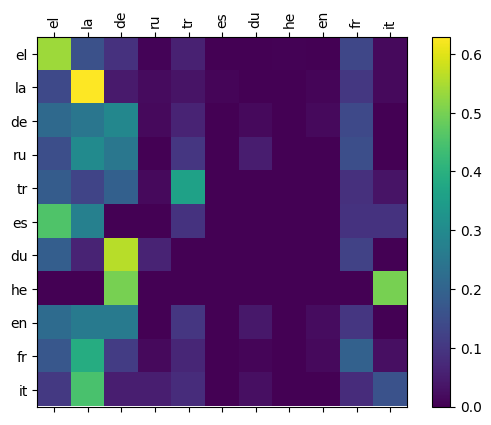

In [24]:
confusion = torch.zeros(len(label_to_id), len(label_to_id))
for predicted, actual in results:
    confusion[actual][predicted] += 1

for i in range(len(label_to_id)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(label_to_id.keys()), rotation=90)
ax.set_yticklabels([''] + list(label_to_id.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()